# DATASET과 DATALOADER 

### torch.utils.data.DataLoader / torch.utils.data.Dataset 의 두 가지 데이터 기본 요소를 제공
- Dataset은 샘플과 label(정답)을 저장
- DataLoader은 Dataset을 샘플에 쉽게 접근할 수 있도록 반복 가능한 객체로 감싼다. 

## 데이터셋 불러오기 

### TorchVision에서 Fashion-MNIST 데이터셋을 불러오는 예제
   - 6만개의 학습 데이터와 1만개의 테스트 데이터
   - 흑백의 28x28 이미지, 10개의 클래스 

### Fashion-MNIST 불러오기 
   - root는 학습/테스트 데이터가 저장되는 경로 
   - train은 학습/테스트 데이터셋 여부 설정
   - download = True 는 root에 데이터가 없는 경우 인터넷에서 다운 
   - transform과 target_transform 은 feature과 label, transform을 지정

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download=True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)


c:\Users\user\Desktop\Git\Pytorch_tutorial\venv\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# 데이터셋을 반복하고 시각화하기 
- Dataset 에 리스트 처럼 직접 접근(index) 할 수 있다. 
- train_data 를 matplotlib로 일부를 시각화 

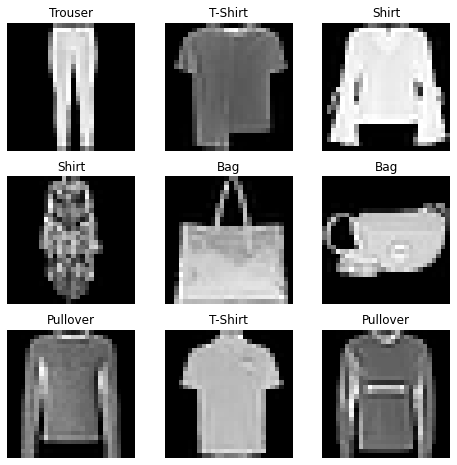

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize = (8,8))

for i in range(1, 10):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(3, 3, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

# 파일에서 사용자 정의 데이터셋 만들기 
- 사용자 정의 Dataset 클래스는 반드시 3개의 함수를 구현해야함 
- ____init____     : Dataset 객체가 생성될 때 한번만 실행 // 이미지와 주석파일이 포함된 디렉토리와 두가지 transform을 초기화
- ____len____      : 함수의 데이터셋의 샘플 개수를 반환 
- ____getitem____  : 주어진 인덱스 idx에 해당하는 샘플을 데이터셋에서 불러오고 반환 

In [3]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, trnasform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

### __getitem__ 추가 정리 
- 인덱스 기반으로 디스크에서 이미지의 위치를 식벽
- read_image 사용하여 이미지를 텐서로 변환 
- self.img_labels 의 csv 데이터로부터 정답(label) 가져온다.
- 해당하는 경우 transform 함수 호출 후 
- 텐서 이미지와 라벨을 dictionary 형으로 반환

In [4]:
def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

## DataLoader로 학습용 데이터 준비
- Dataset 은 데이터의 특징(feature)을 가져오고 하나의 샘플에 label을 지정하는 일을 한번에 함
- 모델을 학습할 때, 일반적으로 미니배치(minibatch)로 전달, 매 epoch 마다 데이터를 다시 섞어 
- 과적합(overfit)을 막고, multiprocessing을 사용하여 데이터 검색 속도를 높이려고 함 

- DataLoader는 간단한 API로 이런 복잡한 과정들을 추상화한 반복 가능한 객체(iteratable)

In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size = 64, shuffle=True) 
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle=True)

## DataLoader를 통해 반복하기(iterate)
- DataLoader에 데이터셋을 불러온 뒤에 필요에 따라 데이터 셋을 iterate 할 수 있습니다.
- 각각 batch_size = 64의 feature와 label을 포함하는 
iterate는 train-features와 train_labes의 batch로 반환
- shuffle = True로 지정했으므로, 모든 배치를 반복하고 데이터가 섞입니다

Feature batch shape : torch.Size([64, 1, 28, 28])
Labels batch shape : torch.Size([64])


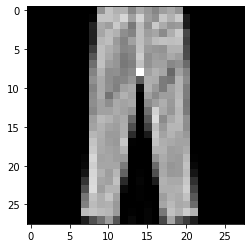

Label : 1


In [9]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape : {train_features.size()}")
print(f"Labels batch shape : {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]

plt.imshow(img, cmap = "gray")
plt.show()
print(f"Label : {label}")